In [1]:
from functools import lru_cache
import numpy as np
from pathlib import Path


paths = Path("/users/mohanana/scratch/data/interim").glob("model*")

models = {
    (substr[0], substr[-2], int(substr[-1])): model
    for model in paths
    if model.name != "model_tmp" and (substr := model.name.split("_"))[-1].isnumeric()
}
n_train = sorted(models)
n_train[:3], "...", n_train[-3:]

([('model', 'bluche', 1000),
  ('model', 'bluche', 2000),
  ('model', 'bluche', 3000)],
 '...',
 [('model2', 'flor', 5000),
  ('model2', 'flor', 6000),
  ('model2', 'flor', 7000)])

In [2]:
@lru_cache
def get_error_rates(arch, file):
    rates = {}
    if arch == "octconv":
        arch = "puigcerver_octconv"
    evaluate = file / f"output/washington/{arch}/evaluate.txt"
    if not evaluate.exists():
        return {}

    with evaluate.open() as fp:
        for line in fp:
            if "Error Rate:" in line:
                key, value = line.split(" Error Rate: ")
                rates[key.strip()] = float(value.strip())

    return rates

In [3]:
get_error_rates("flor", models[("model", "flor", 1)])

{'Character': 0.57383333, 'Word': 1.0, 'Sequence': 1.0}

In [4]:
get_error_rates("flor", models[("model", "flor", 7000)])

{'Character': 0.00810238, 'Word': 0.026, 'Sequence': 0.026}

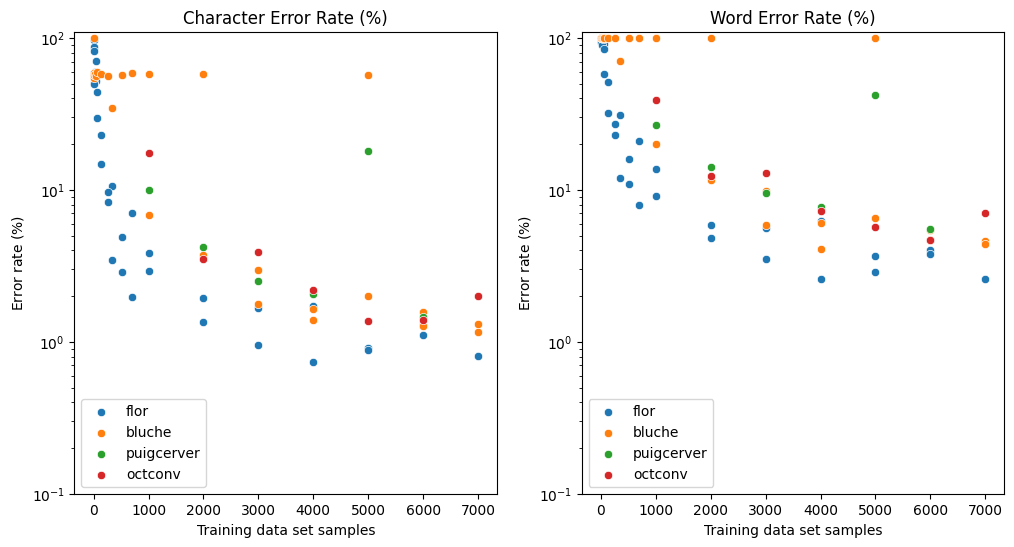

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = None

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 6))

for arch in "flor", "bluche", "puigcerver", "octconv":
    n_train_arch = list(filter(lambda man: man[-2] == arch, n_train))
    WER = 100 * np.array(
        [
            get_error_rates(a, models[(m, a, n)]).get("Word", np.nan)
            for m, a, n in n_train_arch
        ]
    )

    CER = 100 * np.array(
        [
            get_error_rates(a, models[(m, a, n)]).get("Character", np.nan)
            for m, a, n in n_train_arch
        ]
    )

    model_prefixes = [m for m, _, _ in n_train_arch]
    ns = [n for _, _, n in n_train_arch]
    data_arch = pd.DataFrame.from_dict(
        {"model_prefix": model_prefixes, "n": ns, f"WER": WER, f"CER": CER}
    )  # .set_index("n")

    sns.scatterplot(data_arch, x="n", y="CER", ax=ax0, label=arch)  # , lowess=True)
    sns.scatterplot(data_arch, x="n", y="WER", ax=ax1, label=arch)  # , lowess=True)
    if data is None:
        data = data_arch
    elif data_arch.size:
        data = pd.merge(
            data,
            data_arch,
            on=("model_prefix", "n"),
            how="outer",
            suffixes=("", f":{arch}"),
        )

ax0.set_title("Character Error Rate (%)")
ax1.set_title("Word Error Rate (%)")
for ax in ax0, ax1:
    ax.set(
        yscale="log",
        xlabel="Training data set samples",
        ylabel=r"Error rate ($\%$)",
        ylim=(0.1, 110),
    )
    ax.legend()

In [6]:
data

model_prefix     n    WER        CER  WER:bluche  CER:bluche  \
0         model     1  100.0  57.383333         NaN         NaN   
1         model     2  100.0  96.933333         NaN         NaN   
2         model     4  100.0  55.933333         NaN         NaN   
3         model     7  100.0  58.700000         NaN         NaN   
4         model     8  100.0  57.764286         NaN         NaN   
5         model    16  100.0  59.183333         NaN         NaN   
6         model    32  100.0  59.900000         NaN         NaN   
7         model    42  100.0  70.683333         NaN         NaN   
8         model    49   91.0  52.464286         NaN         NaN   
9         model    64   58.0  29.900000         NaN         NaN   
10        model   128   32.0  14.783333         NaN         NaN   
11        model   256   23.0   8.366667         NaN         NaN   
12        model   343   31.0  10.676190         NaN         NaN   
13        model   512   16.0   4.919048         NaN         NaN   
14        model   700    8.0   1.966667         NaN         NaN   
15        model  1000   13.8   3.823333   20.000000    6.860000   
16        model  2000    4.8   1.350238  100.000000   57.630000   
17        model  3000    3.5   0.955952    5.900000    1.773333   
18        model  4000    6.2   1.730952    6.100000    1.645000   
19        model  5000    2.9   0.911667  100.000000   57.264048   
20        model  6000    4.0   1.295000    4.700000    1.261905   
21        model  7000    2.6   0.810238    4.600000    1.320000   
22       model2     1   99.0  86.683333  100.000000  100.000000   
23       model2     2  100.0  81.766667  100.000000   54.466667   
24       model2     4  100.0  57.433333  100.000000   57.816667   
25       model2     7  100.0  55.366667  100.000000   57.500000   
26       model2     8   94.0  50.933333  100.000000   58.716667   
27       model2    16   90.0  50.100000  100.000000   56.716667   
28       model2    32   99.0  57.600000  100.000000   58.357143   
29       model2    49  100.0  57.666667  100.000000   56.216667   
30       model2    64   85.0  44.366667  100.000000   59.366667   
31       model2   128   51.0  23.116667  100.000000   58.066667   
32       model2   256   27.0   9.702381  100.000000   56.016667   
33       model2   343   12.0   3.450000   71.000000   34.466667   
34       model2   512   11.0   2.885714  100.000000   57.000000   
35       model2   700   21.0   7.066667  100.000000   58.883333   
36       model2  1000    9.1   2.920952  100.000000   58.310000   
37       model2  2000    5.9   1.940000   11.700000    3.725238   
38       model2  3000    5.6   1.668333    9.800000    2.971667   
39       model2  4000    2.6   0.735476    4.104104    1.393775   
40       model2  5000    3.7   0.880952    6.500000    1.991190   
41       model2  6000    3.8   1.108571    5.405405    1.561562   
42       model2  7000    NaN        NaN    4.400000    1.160000   

    WER:puigcerver  CER:puigcerver  WER:octconv  CER:octconv  
0              NaN             NaN          NaN          NaN  
1              NaN             NaN          NaN          NaN  
2              NaN             NaN          NaN          NaN  
3              NaN             NaN          NaN          NaN  
4              NaN             NaN          NaN          NaN  
5              NaN             NaN          NaN          NaN  
6              NaN             NaN          NaN          NaN  
7              NaN             NaN          NaN          NaN  
8              NaN             NaN          NaN          NaN  
9              NaN             NaN          NaN          NaN  
10             NaN             NaN          NaN          NaN  
11             NaN             NaN          NaN          NaN  
12             NaN             NaN          NaN          NaN  
13             NaN             NaN          NaN          NaN  
14             NaN             NaN          NaN          NaN  
15            26.8        9.952857    38.93893